# Matrix Factorization for Movie Recommendations in Python

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
cd "/content/drive/MyDrive/ml-latest-small"

/content/drive/.shortcut-targets-by-id/11Sif2PW8zg9I55Bzwvf9hhvMUQskzQq5/ml-latest-small


## Data Exploration

In [3]:
import pandas as pd
import numpy as np

# Read the csv data files
movies_df = pd.read_csv("movies.csv",
                        usecols=['movieId', 'title'],
                        dtype={'movieId': 'int32', 'title': 'str'})
ratings_df = pd.read_csv('ratings.csv',
                         usecols=['userId', 'movieId', 'rating'],
                         dtype={'userId': 'int32', 'movieId': 'int32', 'rating': 'float32'})
movies_df['movieId'] = movies_df['movieId'].apply(pd.to_numeric)

In [4]:
# Print the top 5 values of movies dataframe
movies_df.head()

,movieId,title
0,1,Toy Story (1995)
1,2,Jumanji (1995)
2,3,Grumpier Old Men (1995)
3,4,Waiting to Exhale (1995)
4,5,Father of the Bride Part II (1995)


In [5]:
# Print the top 5 values of ratings dataframe
ratings_df.head()

,userId,movieId,rating
0,1,1,4.0
1,1,3,4.0
2,1,6,4.0
3,1,47,5.0
4,1,50,5.0


In [6]:
# Generate an R dataframe using pivot tables
# where Rows=Users and Columns=Movies, data=Ratings
R_df = ratings_df.pivot(index = 'userId', columns ='movieId', values = 'rating')
R_df.head()

# Calculate the mean ratings given by each user
users_mean=np.array(R_df.mean(axis=1))

# Fill up the NAN values of data with mean value inorder to keep the mean constant.
R_df=R_df.fillna(R_df.mean())

# Generate a Dataframe where each data had been subtracted by mean value of user
R_demean=R_df.sub(R_df.mean(axis=1), axis=0)

## Optimal value of K for Truncated SVD

In [7]:
n_users =int(max(ratings_df.userId))
n_items =int(max(ratings_df.movieId))

In [8]:
from sklearn.model_selection import cross_validate as cv
from sklearn.model_selection import train_test_split

train_data, test_data = train_test_split(ratings_df, test_size=0.3)

In [9]:
test_data.head()

,userId,movieId,rating
97652,606,1663,2.0
25050,177,1213,4.0
57225,380,2746,4.0
65306,419,288,1.5
38488,264,3034,2.5


In [10]:
print(train_data.shape)
print(test_data.shape)

(70585, 3)
(30251, 3)


In [11]:
train_data_matrix = np.zeros((n_users, n_items))
for line in train_data.itertuples():
    a=int(line[1]-1)
    b=int(line[2]-1)
    c=line[3]
    train_data_matrix[a,b] = c

test_data_matrix = np.zeros((n_users, n_items))
for line in test_data.itertuples():
    a=int(line[1]-1)
    b=int(line[2]-1)
    c=line[3]
    test_data_matrix[a, b] = c

In [12]:
# Create our own RMSE measurement function:

from sklearn.metrics import mean_squared_error
from math import sqrt
import matplotlib.pyplot as plt

def rmse(prediction, ground_truth):
    prediction = prediction[ground_truth.nonzero()].flatten()
    ground_truth = ground_truth[ground_truth.nonzero()].flatten()
    return sqrt(mean_squared_error(prediction, ground_truth))

In [13]:
# Generate predictions with by dot product of u,s, vt matrices of svds and measure these predictions with RMSE:
import scipy.sparse as sp
from scipy.sparse.linalg import svds

a=[40, 100, 160, 200]
b=[]

for k in a:
    u, s, vt = svds(train_data_matrix, k = k)
    s = np.diag(s)
    X_pred = np.dot(np.dot(u, s), vt) + users_mean.reshape(-1, 1)
    b.append(round(rmse(X_pred, train_data_matrix),6))
    print('RMSE for k='+ str(k) + " : " + str(b[-1]))



RMSE for k=40 : 2.215446
RMSE for k=100 : 2.739238
RMSE for k=160 : 3.024473
RMSE for k=200 : 3.15206


In [14]:
min = float('inf')
index = 0
for i in range(0,len(b)):
    if(b[i]<min):
      min = b[i]
      index = i
K = a[index]

print("a : ", a)
print("b : ", b)
print(K)

a :  [40, 100, 160, 200]
b :  [2.215446, 2.739238, 3.024473, 3.15206]
40


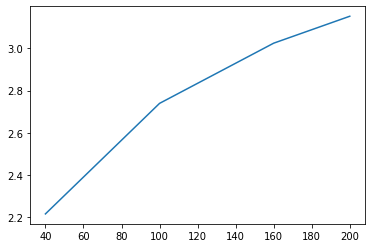

In [15]:
plt.plot(a,b)

## Singular Value Decomposition

In [16]:
# from scipy.linalg import svd

# # svd is function to convert the R_demean to U, sigma, Vt matrix.
# U, sigma, Vt = svd(R_demean)

In [17]:
# # Optimal way to calculate the value of K for truncated SVD
# # 1. We calculated the SVD.
# # 2. We calcualted the sum of square of all singular values.
# # 3. We calcualted the no of values whose sum is 99% of total sum.
# # 4. We got the values of K.

# # Calculated the sum of squares of all singular values.
# sum=0
# for i in sigma:
#     sum += i**2

# # Calculated the K values whose sum of square is 
# # greater than or eqaul to the 99% of the total sum

# required_total = sum * 0.99
# total = 0
# K=0
# for i in range (0,len(sigma)):
#     if required_total > total:
#         total += sigma[i]**2
#         K = i

# print(K)

In [18]:
from scipy.sparse.linalg import svds
print(K)
# Number of singular values and vectors to compute. Must be 1 <= k < min(R_demean.shape).
# svds is function to convert the R_demean to U, sigma, Vt matrix.
U, sigma, Vt = svds(R_demean, k = K)

40


In [19]:
# Converts the Diagonal matrix from 2D to 1D
sigma = np.diag(sigma)

## Making Predictions from the Decomposed Matrices

In [20]:
# Calculate the predicted ratings matrix by dot product of 
# U, sigma, Vt generated with addition of users_mean matrix.
users_predicted_ratings = np.dot(np.dot(U, sigma), Vt) + users_mean.reshape(-1, 1)
print(users_predicted_ratings)

# Convert the matrix into dataframe
predictions_df = pd.DataFrame(users_predicted_ratings, columns = R_df.columns)
print(predictions_df)

[[5.239471  4.775507  4.710407  ... 4.589835  4.589835  5.089621 ]
 [4.6066136 4.13377   3.9231708 ... 4.1856337 4.1856337 4.685732 ]
 [3.0298102 2.5855362 2.407718  ... 2.676985  2.676985  3.1776311]
 ...
 [1.3136638 2.0635433 1.4025731 ... 3.3865805 3.3865805 3.887691 ]
 [3.8605752 3.396995  3.2112453 ... 3.5086536 3.5086536 4.0085144]
 [5.241095  4.2242146 3.3130386 ... 3.8974357 3.8974357 4.3970346]]
movieId    1         2         3       ...    193585    193587    193609
0        5.239471  4.775507  4.710407  ...  4.589835  4.589835  5.089621
1        4.606614  4.133770  3.923171  ...  4.185634  4.185634  4.685732
2        3.029810  2.585536  2.407718  ...  2.676985  2.676985  3.177631
3        4.113807  3.588318  3.276269  ...  3.793987  3.793987  4.294158
4        4.310598  3.799726  3.570427  ...  3.875182  3.875182  4.375241
..            ...       ...       ...  ...       ...       ...       ...
605      4.455659  3.554650  3.688418  ...  3.892610  3.892610  4.391255
606     

In [21]:
# test_data.head()
ratings_df.groupby("userId").count()

,movieId,rating
userId,,
1,232,232
2,29,29
3,39,39
4,216,216
5,44,44
...,...,...
606,1115,1115
607,187,187
608,831,831


In [22]:
predictions_df

movieId,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,34,36,38,39,40,41,42,43,...,185135,185435,185473,185585,186587,187031,187541,187593,187595,187717,188189,188301,188675,188751,188797,188833,189043,189111,189333,189381,189547,189713,190183,190207,190209,190213,190215,190219,190221,191005,193565,193567,193571,193573,193579,193581,193583,193585,193587,193609
0,5.239471,4.775507,4.710407,3.447918,4.233191,5.251077,4.277887,3.951613,4.226242,4.699180,4.832139,3.555109,4.256891,4.938379,4.071936,5.058754,4.781756,4.802562,4.159472,3.573023,4.515731,4.338121,4.205490,4.338405,4.711839,4.584849,4.418118,5.368746,5.265790,4.023795,4.300982,5.188384,4.898212,4.835628,3.276692,4.274576,5.340555,4.770429,4.096429,4.261476,...,5.840035,4.090049,4.090049,3.844365,4.090049,4.335127,4.083467,4.916570,4.980364,6.089193,5.589406,4.763192,4.589835,5.589406,5.089621,5.589406,3.590264,4.090049,4.839395,3.590264,2.090906,3.590264,4.589835,2.590692,5.089621,2.090906,2.590692,2.090906,2.090906,5.589406,4.589835,4.090049,5.089621,5.089621,4.589835,5.089621,4.589835,4.589835,4.589835,5.089621
1,4.606614,4.133770,3.923171,3.041782,3.771264,4.627517,3.878526,3.562051,3.813163,4.195916,4.359324,3.114414,3.811772,4.517864,3.692534,4.607827,4.450034,4.397295,3.410551,3.178971,4.157585,3.910682,3.815282,3.809972,4.288127,4.186418,4.027135,4.914086,4.702026,3.684594,3.872544,4.670218,4.341633,4.498390,2.809700,3.958006,4.935567,4.388396,3.690378,3.874623,...,5.436075,3.685535,3.685535,3.436984,3.685535,3.935699,3.685406,4.550871,4.587832,5.685928,5.185830,4.353373,4.185634,5.185830,4.685732,5.185830,3.185437,3.685535,4.435646,3.185437,1.685143,3.185437,4.185634,2.185241,4.685732,1.685143,2.185241,1.685143,1.685143,5.185830,4.185634,3.685535,4.685732,4.685732,4.185634,4.685732,4.185634,4.185634,4.185634,4.685732
2,3.029810,2.585536,2.407718,1.514681,2.237209,3.160783,2.374130,2.072271,2.308313,2.682346,2.910838,1.611965,2.282445,3.000132,2.162577,3.051277,2.808600,2.843695,2.054255,1.689557,2.667398,2.440815,2.284426,2.238217,2.670064,2.659689,2.497483,3.402500,3.151601,2.194967,2.303291,3.190866,2.823756,2.904341,1.303898,2.440273,3.426854,2.861003,2.163355,2.364310,...,3.929178,2.176339,2.176339,1.933827,2.176339,2.429334,2.176753,3.019535,3.079252,4.178924,3.678277,2.844405,2.676985,3.678277,3.177631,3.678277,1.675693,2.176339,2.927121,1.675693,0.173754,1.675693,2.676985,0.674400,3.177631,0.173754,0.674400,0.173754,0.173754,3.678277,2.676985,2.176339,3.177631,3.177631,2.676985,3.177631,2.676985,2.676985,2.676985,3.177631
3,4.113807,3.588318,3.276269,2.661686,3.479773,3.858113,3.512816,3.163491,3.437879,3.790424,3.997406,2.799506,3.516210,4.108519,3.298019,4.118100,3.885258,3.936493,2.830202,2.722335,3.609182,3.419985,3.423700,3.485963,3.538370,3.782511,3.634910,4.557400,4.339221,3.273832,3.456426,3.644045,3.903382,3.884282,2.435839,3.455481,4.547207,3.946659,3.312088,3.502824,...,5.042892,3.293817,3.293817,3.032675,3.293817,3.536483,3.297901,4.250085,4.191343,5.294499,4.794328,3.956292,3.793987,4.794328,4.294158,4.794328,2.793646,3.293817,4.044452,2.793646,1.293135,2.793646,3.793987,1.793306,4.294158,1.293135,1.793306,1.293135,1.293135,4.794328,3.793987,3.293817,4.294158,4.294158,3.793987,4.294158,3.793987,3.793987,3.793987,4.294158
4,4.310598,3.799726,3.570427,2.726743,3.454194,4.278947,3.555996,3.249186,3.495137,3.872597,4.065341,2.777967,3.490055,4.212522,3.366914,4.298393,4.153989,4.115244,3.065735,2.860338,3.827564,3.588396,3.492993,3.493143,3.981121,3.880061,3.717294,4.605683,4.388092,3.380886,3.565248,4.363814,4.066706,4.181391,2.508007,3.622358,4.624931,4.084433,3.375391,3.560550,...,5.125110,3.375122,3.375122,3.125538,3.375122,3.624593,3.375664,4.244736,4.275474,5.375360,4.875300,4.043630,3.875182,4.875300,4.375241,4.875300,2.875063,3.375122,4.125104,2.875063,1.374885,2.875063,3.875182,1.874944,4.375241,1.374885,1.874944,1.374885,1.374885,4.875300,3.875182,3.375122,4.375241,4.375241,3.875182,4.375241,3.8

In [23]:
test_data.head()

,userId,movieId,rating
97652,606,1663,2.0
25050,177,1213,4.0
57225,380,2746,4.0
65306,419,288,1.5
38488,264,3034,2.5


In [24]:
test_data["userId"]
userID=[]
movieID=[]
for i in range(test_data.shape[0]):
  userID.append(test_data["userId"].iloc[i])
  movieID.append(test_data["movieId"].iloc[i])

In [25]:
x=[]
for i in range(test_data.shape[0]):
  x.append(predictions_df[movieID[i]][userID[i]-1])

In [26]:
a=[]
for i in range(test_data.shape[0]):
  if (predictions_df[movieID[i]][userID[i]-1] < 3):
    a.append(0)
  else:
    a.append(1)
  # a.append(predictions_df[movieID[i]][userID[i]-1])

In [27]:
b=[]
for i in range(test_data.shape[0]):
  if (test_data["rating"].iloc[i]<3):
    b.append(0)
  else:
    b.append(1)  

In [28]:
test_data["predictions"]=x
test_data["predictions_binary"]=a
test_data["original_ratings_binary"]=b

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documen

In [29]:
test_data.head()

,userId,movieId,rating,predictions,predictions_binary,original_ratings_binary
97652,606,1663,2.0,3.986243,1,0
25050,177,1213,4.0,3.778595,1,1
57225,380,2746,4.0,4.397775,1,1
65306,419,288,1.5,3.797822,1,0
38488,264,3034,2.5,3.773193,1,0


In [30]:
truth=0
false=0
for i in range(test_data.shape[0]):
  if a[i]==b[i]:
    truth+=1
  else:
    false+=1

accuracy=truth*100/(truth+false)
print(accuracy)

87.09464149945457


In [39]:
print(accuracy)

87.09464149945457


## Making Movie Recommendations

In [36]:
# Movie recommendation function with arguments:
# 1. Predictions_df is the prediction dataframe
# 2. userID is the userID of the user for which movies to be recommended.
# 3. movies_df is the movies dataframe from the dataset.
# 4. rating_df is the original rating dataframe from the dataset.
# 5. variable to store the number of movies to be recommended.

def recommend_movies(predictions_df, userID, movies_df, ratings_df, n_recommendations=5):
    
    # Get user ID as per row.
    user_row = userID - 1
    
    # Get the user predictions from prediction dataframe in descending order.
    user_predictions = predictions_df.iloc[user_row].sort_values(ascending=False)
    
    # Get the user's data and merge with the movie information such as Title and Genres.
    user_data = ratings_df[ratings_df.userId == (userID)]
    user_full_data = (user_data.merge(movies_df, how = 'left', left_on = 'movieId', right_on = 'movieId').
                     sort_values(['rating'], ascending=False)
                 )

    print('User {0} has already rated {1} movies.'.format(userID, user_full_data.shape[0]))
    print('Recommending the highest {0} predicted ratings movies that are not rated.'.format(n_recommendations))
    
    # Recommend the highest predicted rating movies that the user hasn't seen yet.
    recommendations = (movies_df[~movies_df['movieId'].isin(user_full_data['movieId'])].
                       merge(pd.DataFrame(user_predictions).reset_index(), how = 'left',
                             left_on = 'movieId', right_on = 'movieId').
                       rename(columns = {user_row: 'Predictions'}).
                       sort_values('Predictions', ascending = False).
                       iloc[:n_recommendations, :-1]
                      )

    return user_full_data, recommendations

previous_rated, recommended_movies = recommend_movies(predictions_df, 50, movies_df, ratings_df, 10)

User 50 has already rated 310 movies.
Recommending the highest 10 predicted ratings movies that are not rated.


In [37]:
# The top 10 movies rated by the user
previous_rated.head(10)

,userId,movieId,rating,title
21,50,924,4.5,2001: A Space Odyssey (1968)
33,50,1204,4.5,Lawrence of Arabia (1962)
35,50,1208,4.5,Apocalypse Now (1979)
40,50,1251,4.5,8 1/2 (8½) (1963)
121,50,7327,4.0,Persona (1966)
28,50,1136,4.0,Monty Python and the Holy Grail (1975)
31,50,1199,4.0,Brazil (1985)
32,50,1201,4.0,"Good, the Bad and the Ugly, The (Buono, il bru..."
39,50,1232,4.0,Stalker (1979)
41,50,1252,4.0,Chinatown (1974)


In [38]:
# The recommended movies to the user
recommended_movies

,movieId,title
8773,141718,Deathgasm (2015)
5547,27751,'Salem's Lot (2004)
8623,134095,My Love (2006)
8624,134109,Radio Day (2008)
3572,5059,Little Dieter Needs to Fly (1997)
6342,53578,"Valet, The (La doublure) (2006)"
8640,134796,Bitter Lake (2015)
8642,134847,Ghost Graduation (2012)
6330,53355,Sun Alley (Sonnenallee) (1999)
6326,53280,"Breed, The (2006)"
